In [1]:
import pandas as pd

# 读取数据
df = pd.read_csv("/content/clustered_products.csv")

# 确保 InvoiceDate 是 datetime 格式
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 计算每个客户的购买行为特征
customer_features = df.groupby("CustomerID").agg(
    TotalOrders=("InvoiceNo", "nunique"),  # 订单数
    MinOrderValue=("TotalAmount", "min"),  # 最小订单金额
    MaxOrderValue=("TotalAmount", "max"),  # 最大订单金额
    AvgOrderValue=("TotalAmount", "mean"), # 平均订单金额
    TotalSpent=("TotalAmount", "sum"),     # 总消费金额
    UniqueProductsBought=("StockCode", "nunique"),  # 购买的不同产品种类
    FirstPurchaseDate=("InvoiceDate", "min"),  # 第一次购买时间
    LastPurchaseDate=("InvoiceDate", "max")   # 最近一次购买时间
).reset_index()

# 计算距离上次购买的天数
customer_features["DaysSinceLastPurchase"] = (df["InvoiceDate"].max() - customer_features["LastPurchaseDate"]).dt.days

# 计算购买频率
customer_features["PurchaseFrequency"] = customer_features["TotalOrders"] / (customer_features["DaysSinceLastPurchase"] + 1)

# **计算客户在不同商品类别的消费占比**
# 确保 ProductCluster 存在
if "ProductCluster" not in df.columns:
    raise ValueError("数据集中没有 'ProductCluster'，请先进行产品聚类！")

# 计算每个客户在不同类别的消费占比
category_spend = df.pivot_table(index="CustomerID", columns="ProductCluster", values="TotalAmount", aggfunc="sum", fill_value=0)

# 归一化每个客户在不同类别的消费占比
category_spend = category_spend.div(category_spend.sum(axis=1), axis=0).fillna(0)

# 重命名列
category_spend.columns = [f"Category_{col}" for col in category_spend.columns]

# 合并到 `customer_features`
customer_features = customer_features.merge(category_spend, on="CustomerID", how="left")

# 删除时间字段，确保所有特征数值化
customer_features.drop(columns=["FirstPurchaseDate", "LastPurchaseDate"], inplace=True)

# 显示前几行数据
print(customer_features.head())

# **保存特征数据**
customer_features.to_csv("/content/customer_features.csv", index=False)
print("✅ 客户特征数据已保存！")


   CustomerID  TotalOrders  MinOrderValue  MaxOrderValue  AvgOrderValue  \
0     12346.0            2      -77183.60        77183.6       0.000000   
1     12347.0            7           5.04          249.6      23.681319   
2     12348.0            4          13.20          240.0      57.975484   
3     12349.0            1           6.64          300.0      24.076027   
4     12350.0            1           8.50           40.0      19.670588   

   TotalSpent  UniqueProductsBought  DaysSinceLastPurchase  PurchaseFrequency  \
0        0.00                     1                    325           0.006135   
1     4310.00                   103                      1           3.500000   
2     1797.24                    22                     74           0.053333   
3     1757.55                    73                     18           0.052632   
4      334.40                    17                    309           0.003226   

   Category_0  Category_1  Category_2  Category_3  Category_4 

正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...
正在计算 K=10 ...
正在计算 K=11 ...


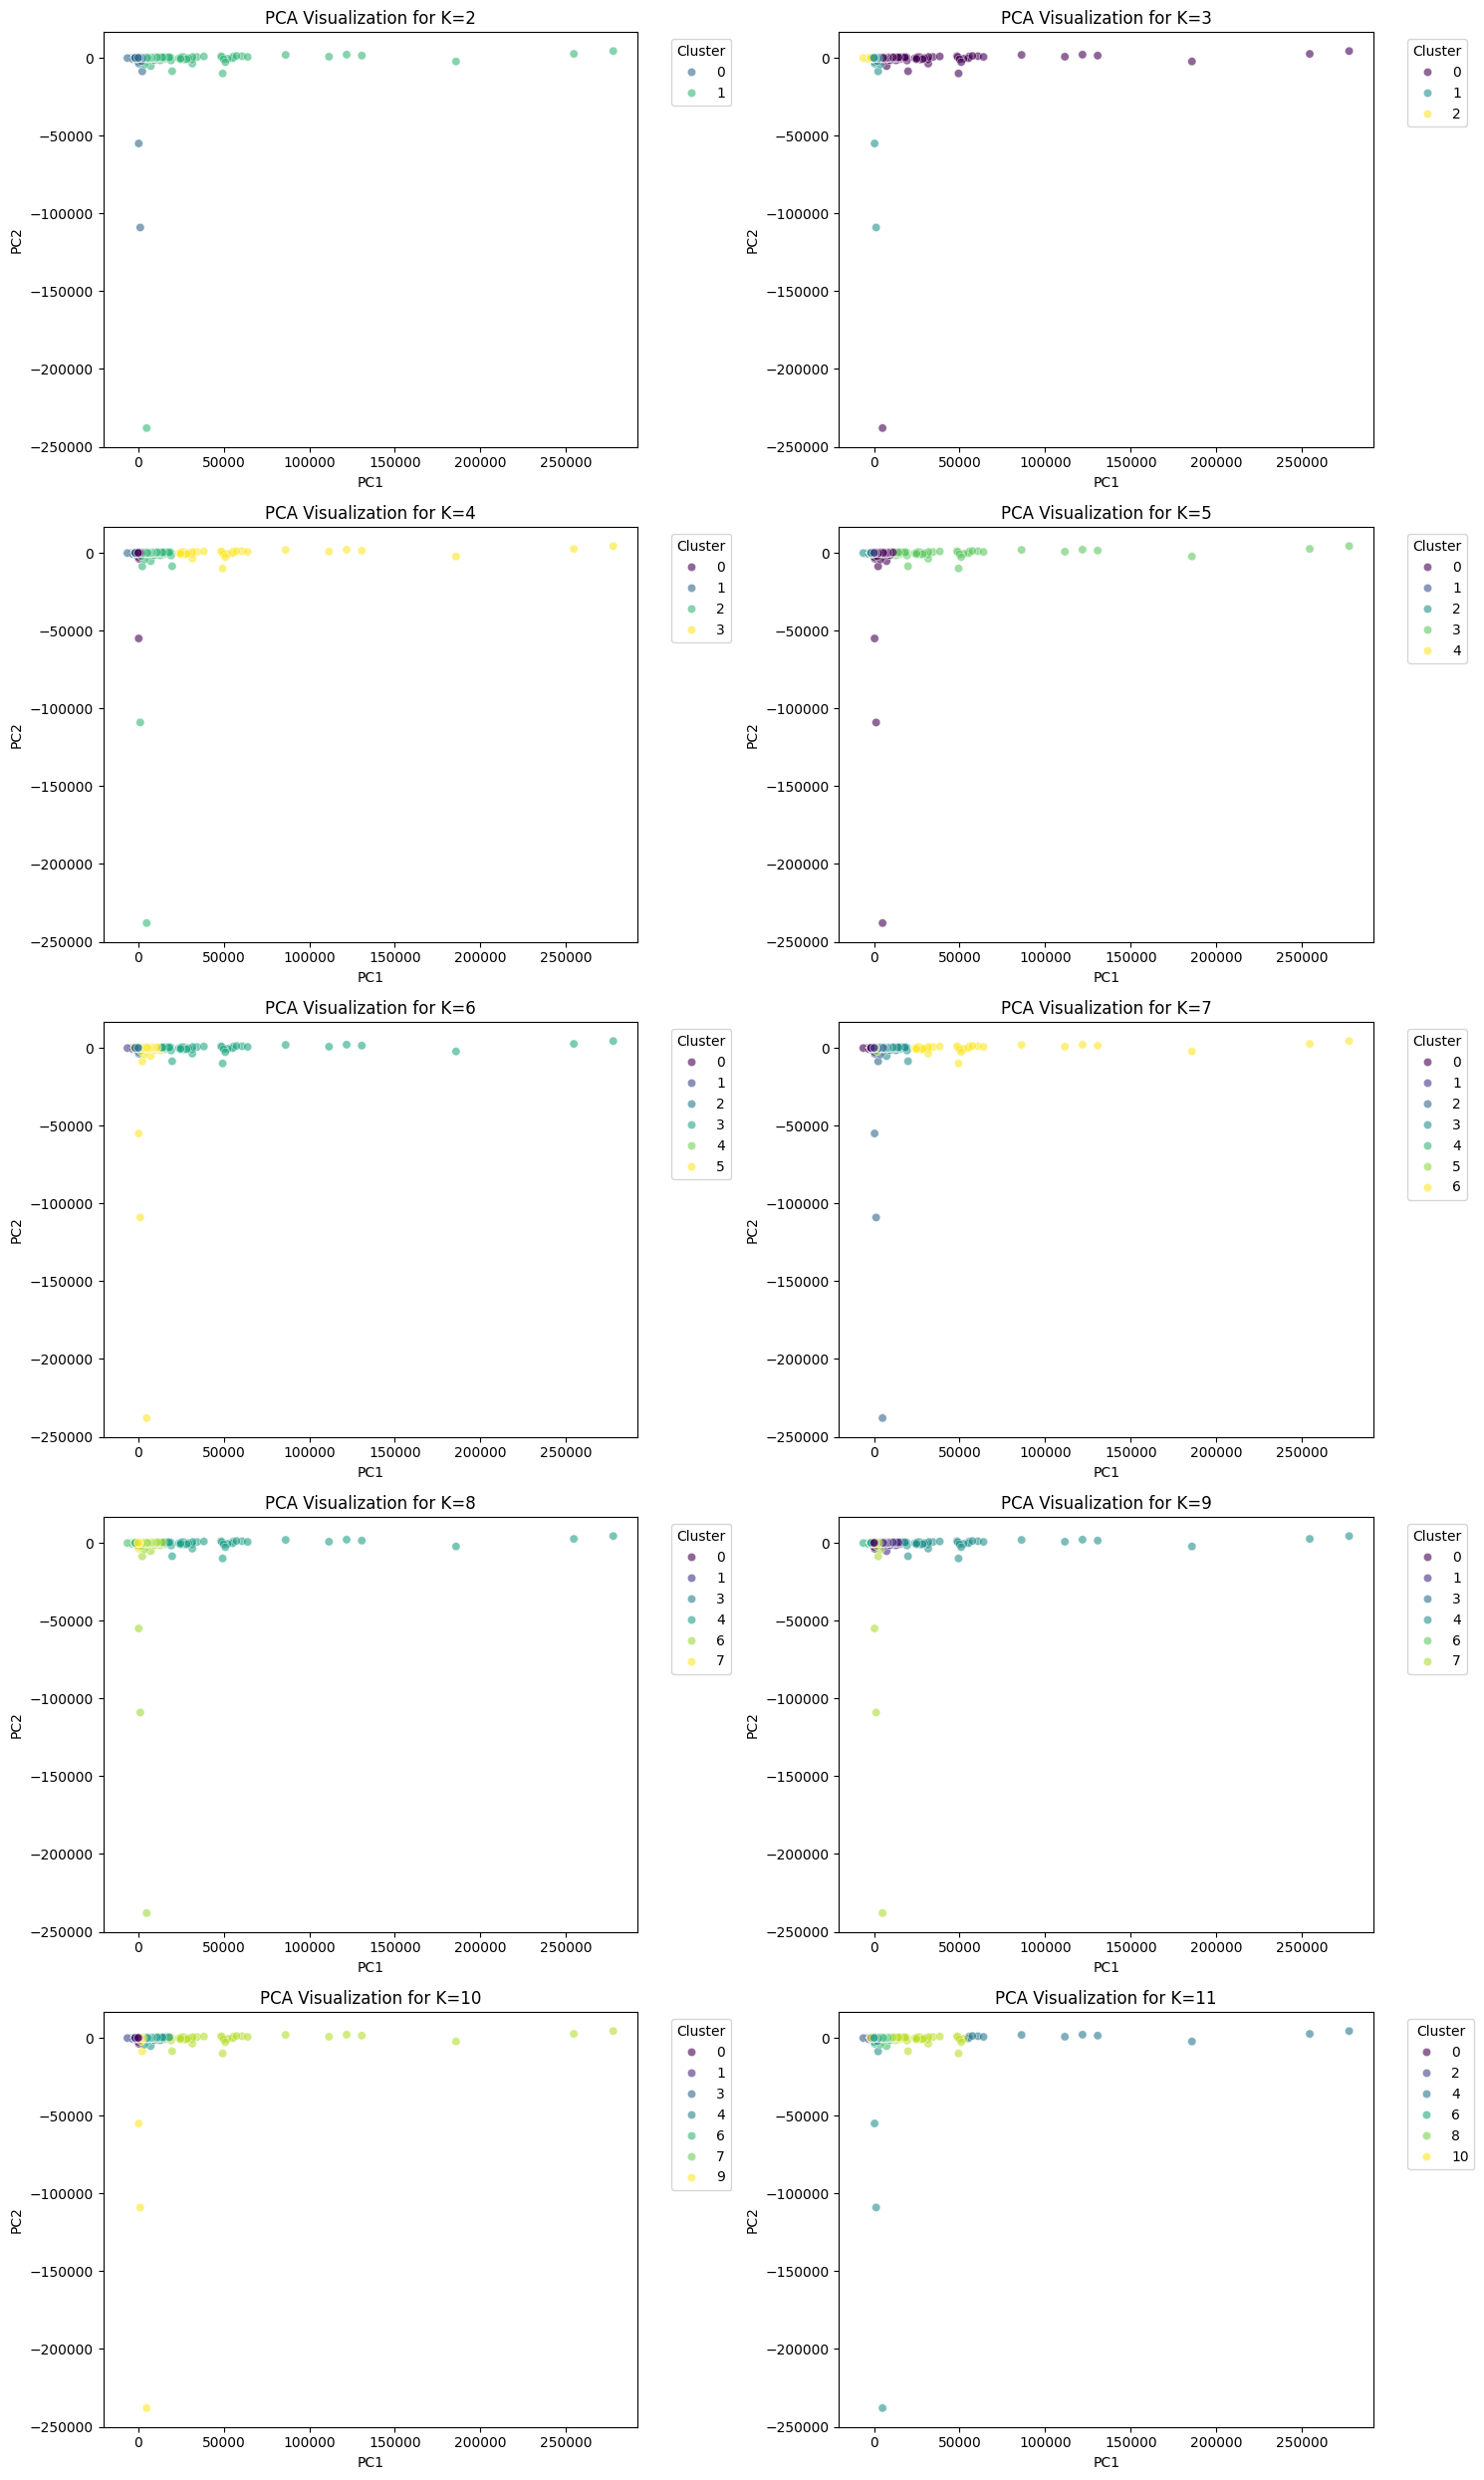

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# 读取客户数据
customer_features = pd.read_csv("/content/customer_features.csv")

# 去除 CustomerID（不用于聚类）
X = customer_features.drop(columns=["CustomerID"])

# 设置 K 值范围
K_range = range(2, 12)  # K=2 到 K=11，共 10 个 K 值

# 创建 5 行 2 列的子图（10 个图）
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 调整 figsize 以适应长宽比
axes = axes.flatten()  # 将 2D 数组转换为 1D，方便索引

for i, k in enumerate(K_range):
    print(f"正在计算 K={k} ...")

    # 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X)

    # PCA 降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # 创建 DataFrame 进行可视化
    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["Cluster"] = labels

    # **绘制 PCA 聚类散点图**
    sns.scatterplot(ax=axes[i], x="PC1", y="PC2", hue="Cluster", palette="viridis", data=df_pca, alpha=0.6)
    axes[i].set_title(f"PCA Visualization for K={k}")
    axes[i].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整子图间距
plt.tight_layout()
plt.show()


正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...
正在计算 K=10 ...
正在计算 K=11 ...


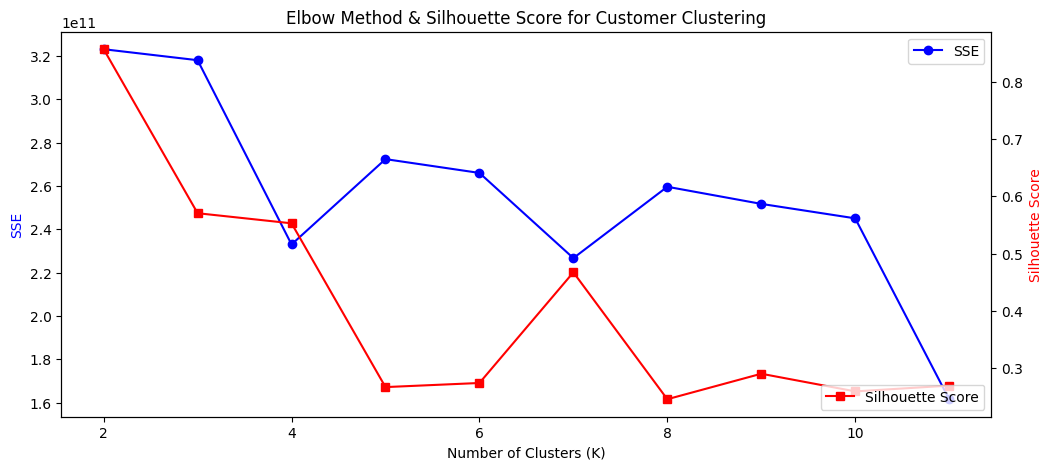

In [3]:
from sklearn.metrics import silhouette_score



# 存储 SSE 和 Silhouette Score
sse = []
silhouette_scores = []

for k in K_range:
    print(f"正在计算 K={k} ...")

    # MiniBatchKMeans 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X)

    # 计算 SSE 和 Silhouette Score
    sse.append(kmeans.inertia_)
    sample_size = min(5000, X.shape[0])
    silhouette_scores.append(silhouette_score(X[:sample_size], labels[:sample_size]))

# **绘制 Elbow Method & Silhouette Score**
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(K_range, sse, marker='o', linestyle='-', color='b', label='SSE')
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='r', label='Silhouette Score')

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE", color='b')
ax2.set_ylabel("Silhouette Score", color='r')
ax1.set_title("Elbow Method & Silhouette Score for Customer Clustering")

ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

plt.show()


In [4]:
# **选择最佳 K 进行 MiniBatchKMeans 聚类**
optimal_k = 7  # 你可以根据上图选择最佳 K
print(f"✅ 选择的最佳 K 值: {optimal_k}")

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=100)
customer_features["CustomerCluster"] = kmeans.fit_predict(X)

# **显示客户分类**
print(customer_features[["CustomerID", "CustomerCluster"]].head(10))

# **保存客户聚类结果**
customer_features.to_csv("/content/clustered_customers.csv", index=False)
print("✅ 客户聚类完成，结果已保存到 clustered_customers.csv")


✅ 选择的最佳 K 值: 7
   CustomerID  CustomerCluster
0     12346.0                2
1     12347.0                2
2     12348.0                1
3     12349.0                1
4     12350.0                0
5     12352.0                1
6     12353.0                0
7     12354.0                4
8     12355.0                0
9     12356.0                5
✅ 客户聚类完成，结果已保存到 clustered_customers.csv


In [5]:
# 计算每个客户群的统计特征
cluster_summary = customer_features.groupby("CustomerCluster").agg(
    TotalOrders_mean=("TotalOrders", "mean"),
    TotalOrders_median=("TotalOrders", "median"),
    TotalSpent_mean=("TotalSpent", "mean"),
    TotalSpent_median=("TotalSpent", "median"),
    PurchaseFrequency_mean=("PurchaseFrequency", "mean"),
    UniqueProductsBought_mean=("UniqueProductsBought", "mean"),
    DaysSinceLastPurchase_mean=("DaysSinceLastPurchase", "mean")
).reset_index()

# 显示数据
display(cluster_summary)


,CustomerCluster,TotalOrders_mean,TotalOrders_median,TotalSpent_mean,TotalSpent_median,PurchaseFrequency_mean,UniqueProductsBought_mean,DaysSinceLastPurchase_mean
0,0,1.844406,1.0,315.357226,305.060,0.082823,25.110140,131.087850
1,1,6.608863,6.0,1918.688054,1880.220,0.890581,92.944123,46.420039
2,2,14.701031,14.0,5398.500722,5304.900,3.443485,157.701031,25.608247
3,3,25.305556,22.5,11587.608426,10487.425,10.004450,183.296296,17.731481
4,4,4.043771,4.0,1020.387689,997.480,0.381247,60.332211,62.287318
5,5,9.464497,9.0,3220.409382,3156.945,1.772030,131.653846,33.896450
6,6,63.323529,49.0,67243.962647,50638.965,36.777937,390.588235,5.852941


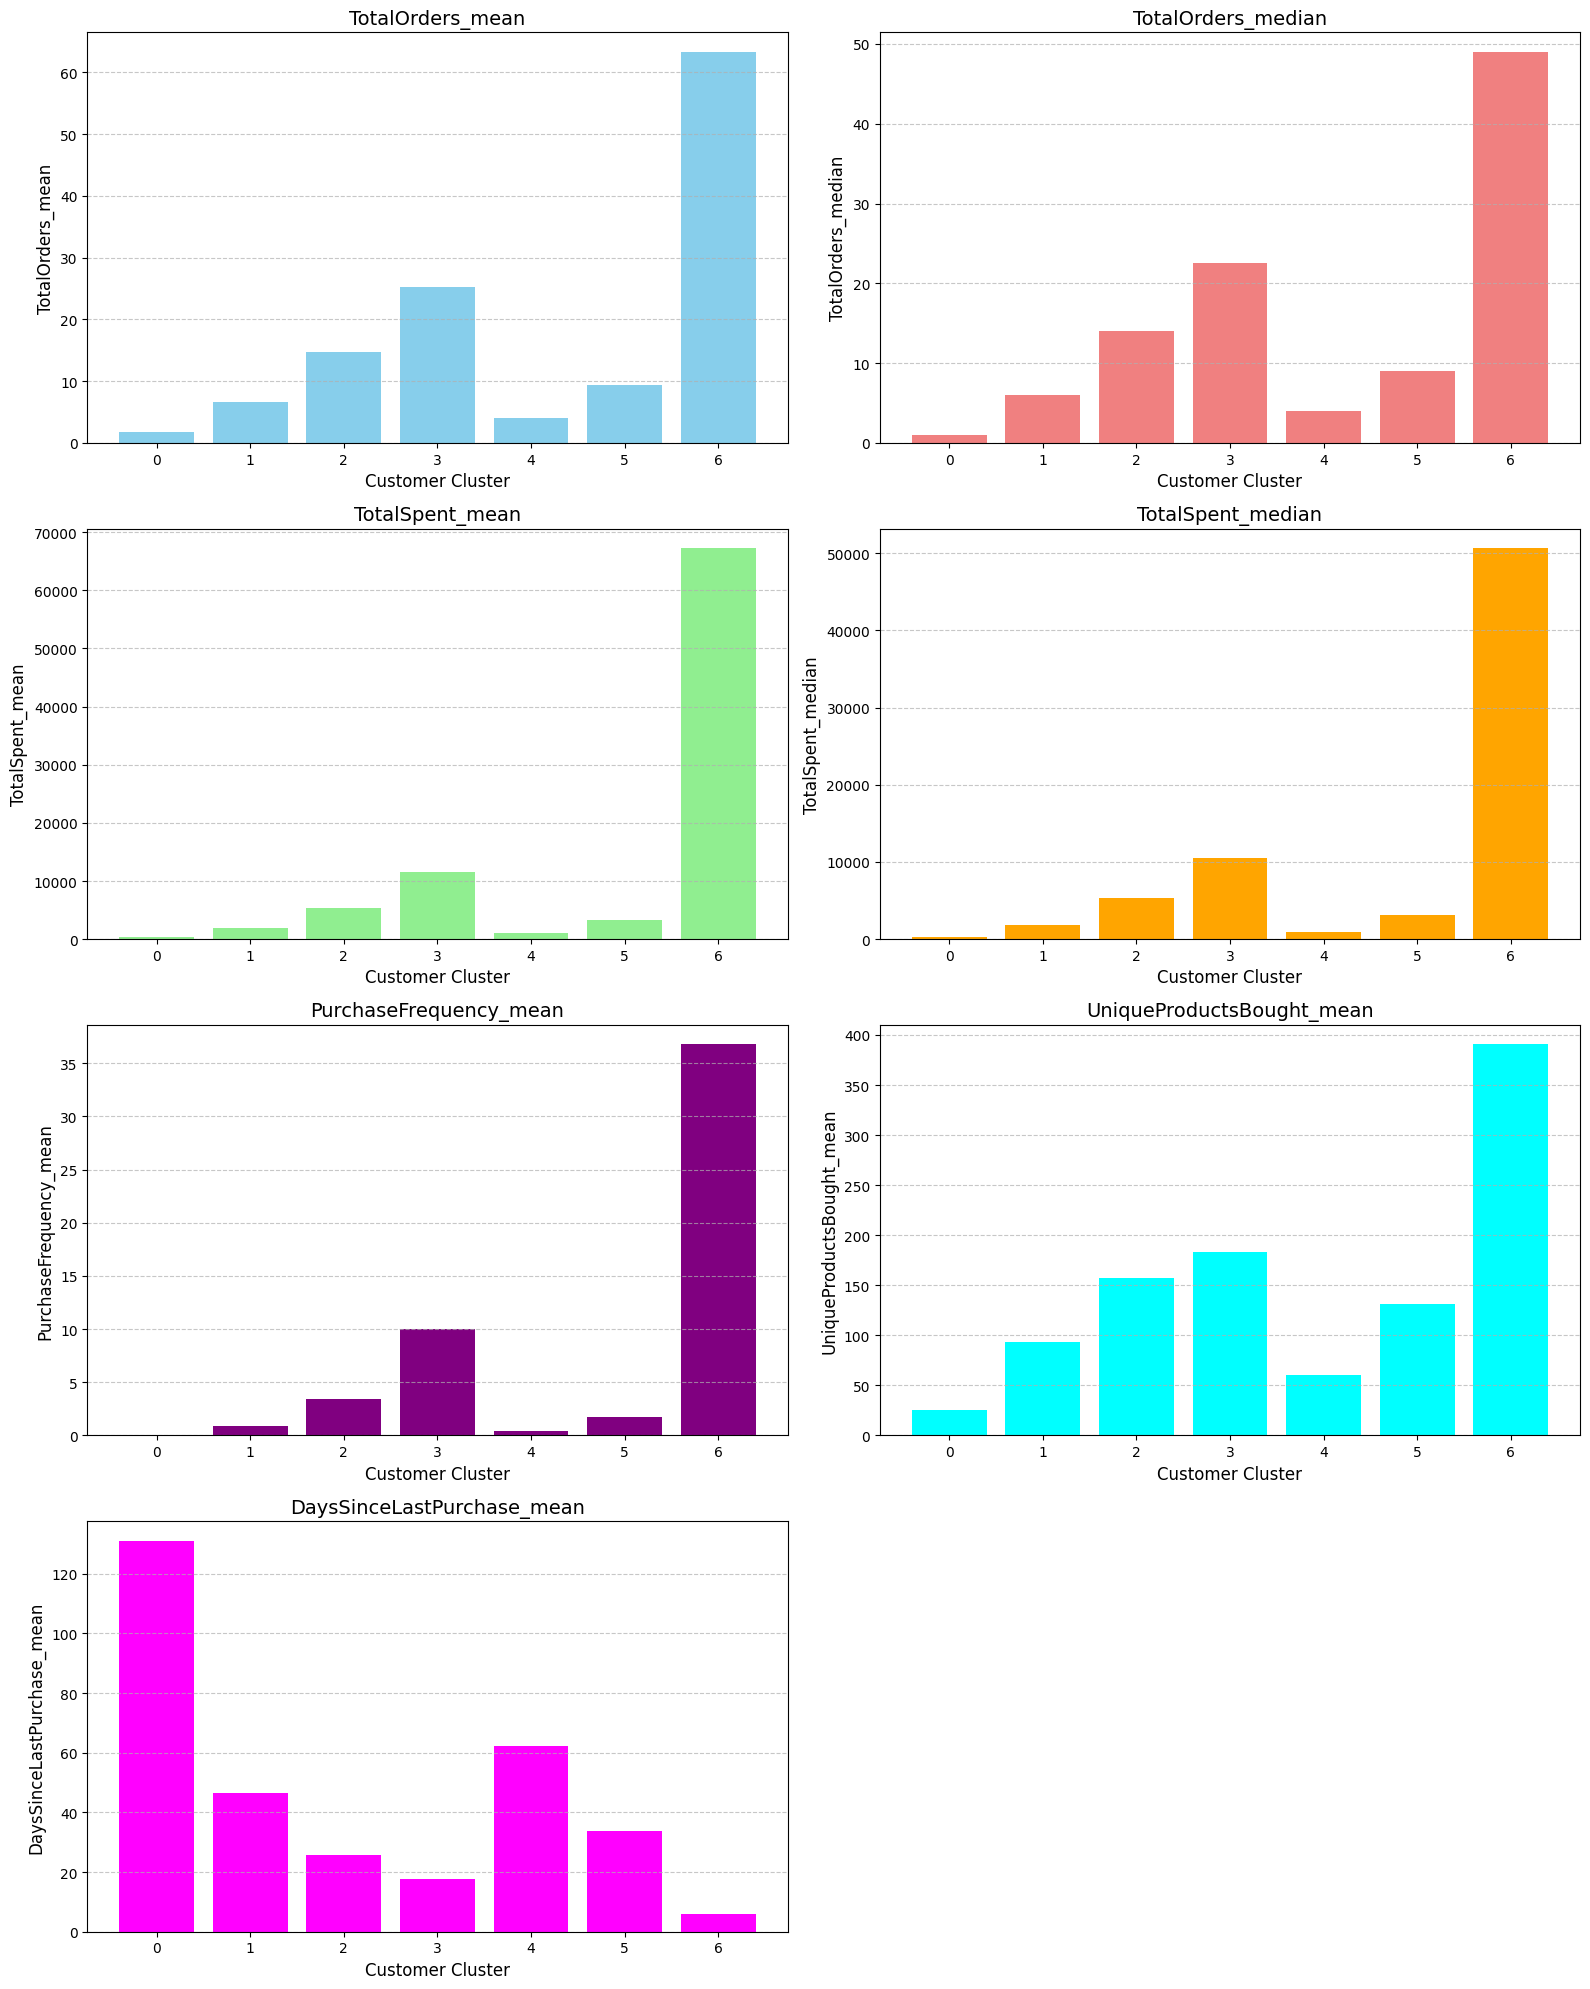

In [6]:

# 创建 4 行 2 列的子图（最后一个图占两列）
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()  # 转为 1D 数组，方便索引

# 要绘制的列
columns = ['TotalOrders_mean', 'TotalOrders_median', 'TotalSpent_mean',
           'TotalSpent_median', 'PurchaseFrequency_mean',
           'UniqueProductsBought_mean', 'DaysSinceLastPurchase_mean']

# 颜色列表
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple', 'cyan', 'magenta']

# 绘制每个柱形图
for i, col in enumerate(columns):
    axes[i].bar(cluster_summary["CustomerCluster"], cluster_summary[col], color=colors[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel("Customer Cluster", fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# 隐藏多余的子图
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# 调整布局
plt.tight_layout()
plt.show()


客户群体占比

饼图显示 不同客户群体的占比，Cluster 0 约占 52%，而 Cluster 6 仅占 0.78%，但贡献了最高的销售额。

,CustomerCluster,Percentage
0,0,52.333028
1,4,20.379689
2,1,11.870997
3,5,7.731016
4,2,4.437328
5,3,2.470265
6,6,0.777676


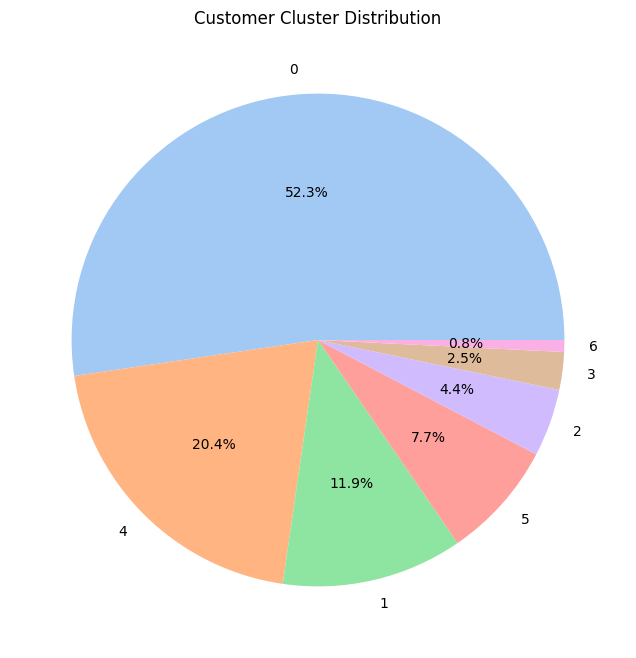

In [7]:
# 计算每个客户群的客户数量占比
cluster_distribution = customer_features["CustomerCluster"].value_counts(normalize=True) * 100
cluster_distribution = cluster_distribution.reset_index()
cluster_distribution.columns = ["CustomerCluster", "Percentage"]

# 显示数据
display(cluster_distribution)
plt.figure(figsize=(8, 8))
plt.pie(cluster_distribution["Percentage"], labels=cluster_distribution["CustomerCluster"], autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Customer Cluster Distribution")
plt.show()



In [8]:
# 计算各客户群的平均消费金额
high_value_clusters = cluster_summary.sort_values("TotalSpent_mean", ascending=False)

# 显示数据
display(high_value_clusters)



,CustomerCluster,TotalOrders_mean,TotalOrders_median,TotalSpent_mean,TotalSpent_median,PurchaseFrequency_mean,UniqueProductsBought_mean,DaysSinceLastPurchase_mean
6,6,63.323529,49.0,67243.962647,50638.965,36.777937,390.588235,5.852941
3,3,25.305556,22.5,11587.608426,10487.425,10.004450,183.296296,17.731481
2,2,14.701031,14.0,5398.500722,5304.900,3.443485,157.701031,25.608247
5,5,9.464497,9.0,3220.409382,3156.945,1.772030,131.653846,33.896450
1,1,6.608863,6.0,1918.688054,1880.220,0.890581,92.944123,46.420039
4,4,4.043771,4.0,1020.387689,997.480,0.381247,60.332211,62.287318
0,0,1.844406,1.0,315.357226,305.060,0.082823,25.110140,131.087850


 一次性 vs 复购客户分析

柱状图对比 一次性购买客户 与 复购客户 的占比，发现约 30.03% 的客户为一次性购买用户，企业应重点关注 如何提高客户留存率。

一次性购买的客户占比：30.03%


<ipython-input-9-a8723b462871>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["One-time Customers", "Repeat Customers"], y=[one_time_count, multi_time_count], palette="Set2")


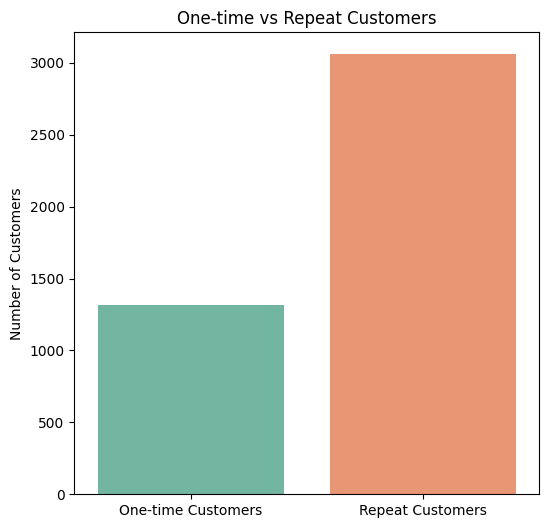

In [9]:
# 计算一次性购买的客户比例
one_time_customers = customer_features[customer_features["TotalOrders"] == 1]
one_time_percentage = len(one_time_customers) / len(customer_features) * 100

print(f"一次性购买的客户占比：{one_time_percentage:.2f}%")

# 计算一次性客户占比
one_time_count = len(one_time_customers)
multi_time_count = len(customer_features) - one_time_count

plt.figure(figsize=(6, 6))
sns.barplot(x=["One-time Customers", "Repeat Customers"], y=[one_time_count, multi_time_count], palette="Set2")
plt.title("One-time vs Repeat Customers")
plt.ylabel("Number of Customers")
plt.show()



客户群体的平均订单量 vs. 平均总消费

通过柱状图和折线图展示 不同客户群体的平均订单量 和 总消费金额，可以直观地看出 Cluster 6 的订单量和消费金额远超其他客户群。

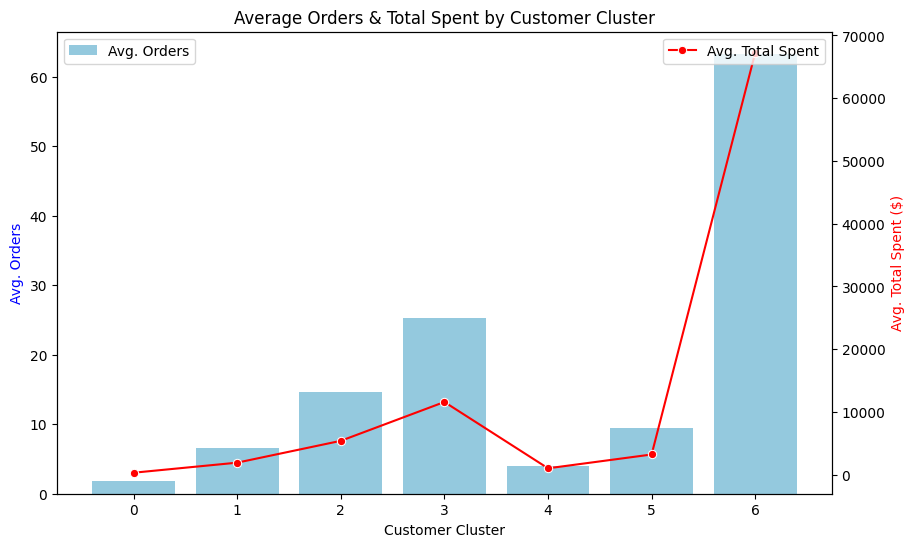

In [10]:
#客户群体的平均订单量 vs. 平均总消费
# 设置画布大小
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制不同客户群的平均订单量
sns.barplot(x="CustomerCluster", y="TotalOrders_mean", data=cluster_summary, ax=ax1, color="skyblue", label="Avg. Orders")

# 创建双 Y 轴
ax2 = ax1.twinx()
sns.lineplot(x="CustomerCluster", y="TotalSpent_mean", data=cluster_summary, ax=ax2, color="red", marker="o", label="Avg. Total Spent")

# 设置标题和标签
ax1.set_xlabel("Customer Cluster")
ax1.set_ylabel("Avg. Orders", color="blue")
ax2.set_ylabel("Avg. Total Spent ($)", color="red")
plt.title("Average Orders & Total Spent by Customer Cluster")

# 显示图例
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


 客户群体的购买频率分布

通过箱线图观察 各个客户群体的购买频率分布，发现 Cluster 6 购买频率最高，而 Cluster 0 和 Cluster 4 购买频率较低。

<ipython-input-11-0f9ca6d40d35>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="CustomerCluster", y="PurchaseFrequency", data=customer_features, palette="coolwarm")


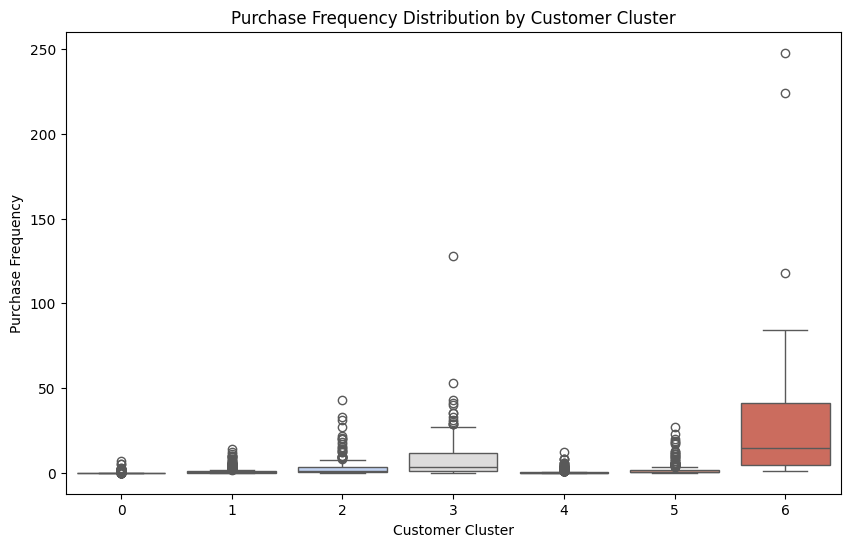

In [11]:
# 客户群体的购买频率分布
plt.figure(figsize=(10, 6))
sns.boxplot(x="CustomerCluster", y="PurchaseFrequency", data=customer_features, palette="coolwarm")
plt.title("Purchase Frequency Distribution by Customer Cluster")
plt.xlabel("Customer Cluster")
plt.ylabel("Purchase Frequency")
plt.show()
